<h1>BERT(Bidirectional Encoder Representations from Transformers)</h1><br>

<p style="font-size: 16px;">It is a transformer-based machine learning technique for natural language processing pre-training developed by Google. BERT was created and published in 2018 by Jacob Devlin and his colleagues from Google.</p>

<p style="font-size: 16px;">BERT uses bidirectional training i.e it reads the sentence from both directions to understand the context of the sentence.</p>

<p style="font-size: 16px;">Note that BERT is just an encoder. It does not have a decoder.</p>

<h1>Transformer</h1>
<br>
<p style="font-size: 16px;">
Google introduced the transformer architecture in the paper “Attention is All you need”. The transformer uses a self-attention mechanism, which is suitable for language understanding.</p>
<p style="font-size: 16px;">
Let’s say “I went to the Himalayas this summer. I really enjoyed my time out there”. The last word “there” refers to the Himalayas. But to understand this, remembering the first few parts is essential. To achieve this, the attention mechanism decides at each step of an input sequence which other parts of the sequence are important.</p>
<p style="font-size: 16px;">
The transformer has an encoder-decoder architecture. They are composed of modules that contain feed-forward and attention layers.</p>

<h1>Pytorch:</h1><br>
<p style="font-size: 16px;">
PyTorch is a Python-based scientific computing package that uses the power of graphics processing units(GPU). Since its release in January 2016, many researchers have continued to increasingly adopt PyTorch. It has quickly become a go-to library because of its ease in building extremely complex neural networks. It is giving a tough competition to TensorFlow especially when used for research work.

Some of the key highlights of PyTorch includes:

Simple Interface: It offers easy to use API.

Pythonic in nature: This library, being Pythonic, smoothly integrates with the Python data science stack.

Tensors: It is basically the same as a NumPy array. To run operations on the GPU, just cast the Tensor to a Cuda datatype.

Computational graphs: PyTorch provides an excellent platform that offers dynamic computational graphs.

AUTOGRAD(Automatic Differentiation): This class is an engine to calculate derivatives.</p>

<h1>Import Libraries</h1>
<p style="font-size: 16px;">Importing the libraries that are required to perform operations on the dataset.</p>

In [1]:
import numpy as np
import pandas as pd
import re
import torch
import random
import torch.nn as nn
import transformers
import matplotlib.pyplot as plt# specify GPU
device = torch.device('mps')
print(device)

mps


<h1>Load Dataset</h1>
We load the training dataset here

In [4]:
train_df = pd.read_csv('./data/processed/train.csv')
test_df = pd.read_csv('./data/processed/test.csv')

train_df = train_df.loc[:, ~train_df.columns.str.contains('^Unnamed')]
test_df = test_df.loc[:, ~test_df.columns.str.contains('^Unnamed')]

train_df.head()

,text,label
0,"I want a flat white , please .",1
1,I want a salted caramel hot chocolate .,1
2,Have a great day !,4
3,Hey there !,3
4,"Could I get a black tea , please ?",1


<h4>To convert these categorical labels into numerical encodings we are using the LabelEncoder.</h4>

In [3]:
# Converting the labels into encodings
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_df['label'] = le.fit_transform(train_df['label'])# check class distribution

# check class distribution
train_df['label'].value_counts(normalize = True)

0    0.25
3    0.25
2    0.25
1    0.25
Name: label, dtype: float64

In [6]:
#preparing data
train_text, train_labels = train_df['text'], train_df['label']
test_text, test_labels = test_df['text'], test_df['label']

<h1>BERT Model</h1>
Importing the Bert model.

In [5]:
from transformers import AutoModel, BertTokenizerFast# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')# Import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
# get length of all the messages in the train set
seq_len = []
for i in train_text:
    j = str(i)
    seq_len.append(len(j.split()))
    


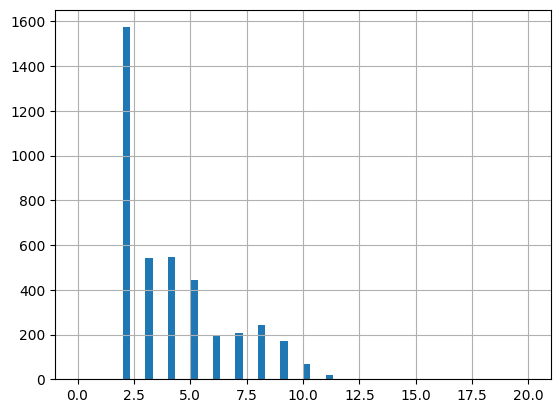

In [7]:
# Based on the histogram we are selecting the max len as 8
pd.Series(seq_len).hist(bins = 60, range=(0,20))
max_seq_len = 8

In [8]:
#Tokenization: breaking down of the sentence into tokens
# tokenize and encode sequences in the training set
tokens_train = tokenizer(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/opt/miniconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2304: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


<p style='font-size: 16px;'>Next, we will convert the integer sequences to tensors.</p>

In [9]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

<p style="font-size: 18px;">Now we will create dataloaders for the training set. These dataloaders will pass batches of train data as input to the model during the training phase.</p>

In [10]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
#define a batch size
batch_size = 16
# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)
# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)
# DataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)


<h1>Define Model Architecture</h1>

RELU - The rectified linear activation function or ReLU for short is a piecewise linear function that will output the input directly if it is positive, otherwise, it will output zero.

In [8]:
class BERT_Arch(nn.Module):
    
    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        self.bert=bert #model assign
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU() 
        self.fc1 = nn.Linear(768,512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 4)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, sent_id, mask):
        cls_hs = self.bert(sent_id, attention_mask=mask)[0][:,0]
        
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc3(x)
        
        x = self.softmax(x)
        
        return x


In [12]:
# freeze all the parameters. This will prevent updating of model weights during fine-tuning.

for param in bert.parameters():
    param.requires_grad = False

model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                                  Param #
BERT_Arch                                               --
├─BertModel: 1-1                                        --
│    └─BertEmbeddings: 2-1                              --
│    │    └─Embedding: 3-1                              (23,440,896)
│    │    └─Embedding: 3-2                              (393,216)
│    │    └─Embedding: 3-3                              (1,536)
│    │    └─LayerNorm: 3-4                              (1,536)
│    │    └─Dropout: 3-5                                --
│    └─BertEncoder: 2-2                                 --
│    │    └─ModuleList: 3-6                             (85,054,464)
│    └─BertPooler: 2-3                                  --
│    │    └─Linear: 3-7                                 (590,592)
│    │    └─Tanh: 3-8                                   --
├─Dropout: 1-2                                          --
├─ReLU: 1-3                                             --
├─Linea

<h1>Optimizer</h1>
When training a deep learning model, you must adapt every epoch's weight and minimize the loss function. An optimizer is an algorithm or function that adapts the neural network's attributes, like learning rate and weights. Hence, it assists in improving the accuracy and reduces the total loss

Adam is a replacement optimization algorithm for stochastic gradient descent for training deep learning models. Adam combines the best properties of the AdaGrad and RMSProp algorithms to provide an optimization algorithm that can handle sparse gradients on noisy problems

In [13]:
from torch.optim import Adam
# define the optimizer
optimizer = Adam(model.parameters(), lr = 1e-2)

<h1>Find Class Weights</h1>

Estimate class weights for unbalanced datasets.



In [14]:
from sklearn.utils.class_weight import compute_class_weight
#compute the class weights
print(train_labels)
class_wts = compute_class_weight(class_weight='balanced', classes = np.unique(train_labels), y=train_labels)
print(class_wts)

0       2
1       1
2       2
3       0
4       1
       ..
3995    0
3996    3
3997    3
3998    3
3999    3
Name: label, Length: 4000, dtype: int64
[1. 1. 1. 1.]


<h1>Balancing the weights while calculating the error</h1>


what is cross entropy loss
Also called logarithmic loss, log loss or logistic loss. Each predicted class probability is compared to the actual class desired output 0 or 1 and a score/loss is calculated that penalizes the probability based on how far it is from the actual expected value.

In [15]:
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)
print(weights)
# loss function
cross_entropy = nn.NLLLoss(weight=weights) 
print(cross_entropy)

tensor([1., 1., 1., 1.], device='mps:0')
NLLLoss()


/opt/miniconda3/lib/python3.9/site-packages/torch/_tensor_str.py:115: UserWarning: The operator 'aten::nonzero' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  nonzero_finite_vals = torch.masked_select(


<h1>Setting up the epochs</h1>


In [16]:
train_losses=[]# number of training epochs
epochs = 20
# We can also use learning rate scheduler to achieve better results
lr_sch = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

<h1>Fine-Tune the model</h1>

In [17]:
def train():
    model.train()
    total_loss = 0
    total_preds = []
    
    correct = 0
    
    for step, batch in enumerate(train_dataloader):
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch
        preds = model(sent_id, mask)
        
        loss = cross_entropy(preds, labels)
        total_loss = total_loss + loss.item()
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        optimizer.zero_grad()
        preds=preds.detach().cpu().numpy()
        total_preds.append(preds)
        
        labels = labels.detach().cpu().numpy()
        preds = np.argmax(preds, axis = 1)
        if (labels == preds).all():
            correct+=1
        
    avg_loss = total_loss / len(train_dataloader)
    total_preds  = np.concatenate(total_preds, axis=0)
    print('accuracy: ', correct / len(train_dataloader), "%")
    return avg_loss, total_preds


<h1>Start Model Training</h1>

In [18]:
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    # append training and validation loss
    train_losses.append(train_loss)  
    # it can make your experiment reproducible, similar to set  random seed to all options where there needs a random seed.    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print(f'\nTraining Loss: {train_loss:.3f}')


 Epoch 1 / 20
  Batch    50  of    250.
  Batch   100  of    250.
  Batch   150  of    250.
  Batch   200  of    250.
accuracy:  0.548 %

Training Loss: 0.278

 Epoch 2 / 20
  Batch    50  of    250.
  Batch   100  of    250.
  Batch   150  of    250.
  Batch   200  of    250.
accuracy:  0.616 %

Training Loss: 0.232

 Epoch 3 / 20
  Batch    50  of    250.
  Batch   100  of    250.
  Batch   150  of    250.
  Batch   200  of    250.
accuracy:  0.728 %

Training Loss: 0.170

 Epoch 4 / 20
  Batch    50  of    250.
  Batch   100  of    250.
  Batch   150  of    250.
  Batch   200  of    250.
accuracy:  0.7 %

Training Loss: 0.117

 Epoch 5 / 20
  Batch    50  of    250.
  Batch   100  of    250.
  Batch   150  of    250.
  Batch   200  of    250.
accuracy:  0.836 %

Training Loss: 0.099

 Epoch 6 / 20
  Batch    50  of    250.
  Batch   100  of    250.
  Batch   150  of    250.
  Batch   200  of    250.
accuracy:  0.676 %

Training Loss: inf

 Epoch 7 / 20
  Batch    50  of    250.
  B

<h1>Get Predictions for Test Data</h1>

In [19]:
labels = {1: 'order', 2: 'size',  3: 'greeting', 4: 'thank'}

def get_prediction(str):
    str = re.sub(r'[^a-zA-Z]+', '', str)
    test_text = [str]
    model.eval()
    
    tokens_test_data = tokenizer(
        test_text,
        max_length = 8,
        pad_to_max_length = True,
        truncation=True,
        return_token_type_ids = False
    )
    
    test_seq = torch.tensor(tokens_test_data['input_ids'])
    test_mask = torch.tensor(tokens_test_data['attention_mask'])

    preds = None 
    with torch.no_grad():
        preds = model(test_seq.to(device), test_mask.to(device))
    
    preds = preds.detach().cpu().numpy()
    preds = np.argmax(preds, axis = 1)
    return le.inverse_transform(preds)[0]


In [20]:
labels = {1: 'order', 2: 'size',  3: 'greeting', 4: 'thank'}
correct =0

for i in range(len(test_text)):
    result = get_prediction(test_text[i])
    print(test_text[i], '- result - ', result)
    if result == test_labels[i]:
        correct +=1
        
print("accuracy: ", (correct / len(test_text))*100, "%")

Medium cup . - result -  2
A mocha . - result -  1
Have a nice day ! - result -  1
I want a noisette , please . - result -  1
Hi ! - result -  3
Hey ! - result -  3
Large . - result -  2
Medium cup . - result -  2
Cheers ! - result -  4
Could I get a noisette ? - result -  1
Have a great day ! - result -  4
Small , thank you ! - result -  2
Goodbye ! - result -  4
Medium , thank you ! - result -  2
Goodbye ! - result -  4
Can I get a peppermint hot chocolate ? - result -  2
A white hot chocolate , please . - result -  1
I would like an espresso con panna . - result -  1
I want a salted caramel hot chocolate , please . - result -  4
Hey ! - result -  3
A white hot chocolate , please . - result -  1
I would like an americano , please . - result -  1
Enjoy your day ! - result -  4
Alright . - result -  4
Hello ! - result -  3
A black tea . - result -  1
I want a flat white . - result -  4
Hi ! - result -  3
Small , please . - result -  2
Have a nice day ! - result -  1
Can I get an espres

May I get a latte ? - result -  1
I would like an espresso . - result -  1
Alright . - result -  4
Could I have a noisette , please ? - result -  1
Hello ! - result -  3
Goodbye ! - result -  4
Have a great day ! - result -  4
I want a salted caramel hot chocolate , please . - result -  4
Large , thank you ! - result -  2
Small would do . - result -  2
Bye ! - result -  4
Medium . - result -  2
Hello ! - result -  3
Hi ! - result -  3
Bye ! - result -  4
Okay . - result -  4
Okay . - result -  4
Hey there ! - result -  4
Small , thank you ! - result -  2
Medium , please . - result -  2
Have a nice day ! - result -  1
Could I get a peppermint hot chocolate ? - result -  1
Hey there ! - result -  4
Small , please . - result -  2
Can I get a mocha ? - result -  1
Hi ! - result -  3
Hi ! - result -  3
Hello ! - result -  3
Small , please . - result -  2
Hi ! - result -  3
Have a nice day ! - result -  1
Medium would do . - result -  2
Hey there ! - result -  4
Okay . - result -  4
Okay . -

<h1>Let's test the model now:</h1>

In [35]:
s = "Can i get black tea"
result = get_prediction(s)
print(labels[result])

order


<h1>Save model</h1>

In [56]:
PATH='/Users/aon97/programming/chatbot/model/chatbotmodel1.pth'

In [57]:
torch.save(model, PATH)

In [64]:
PATH='/Users/aon97/programming/chatbot/model/chatbotmodel.pth'
model = BERT_Arch(bert)
model.load_state_dict(torch.load(PATH))
model = model.to(device)